[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/Xee/blob/main/docs/client-vs-server.ipynb)


# Client vs. Server

**When you use Xee, you have to decide where to run your computations: on the Earth Engine servers or locally on the client**. Your decision will depend on the relative importance of performance, flexibility, code readability, and process control (and if you're a commercial EE user, cost). If you're unfamiliar with Earth Engine, a helpful analogy is working with a relational database and pandas: just as you might choose between SQL operations in the database versus pandas operations in your application, with Xee you can perform calculations either on Earth Engine's servers or locally with Xarray.

**Like database operations, the key tradeoff is between processing at the data source versus locally after download**. Earth Engine can efficiently process global-scale data but limits you to its built-in operations, while local processing gives you full Python flexibility but requires downloading the data first.

For best results, follow this general workflow: first reduce your data as much as practical using Earth Engine's built-in operations, then transfer the reduced dataset to your local environment for further analysis or visualization. **Earth Engine excels at common geospatial operations like**:

- Temporal aggregation (annual means, monthly totals)
- Spatial reductions (regional averages, zonal statistics)
- Band math and basic calculations
- Filtering and masking
- Band selection
- Resampling and reprojecting

Once you've reduced your data to a manageable size, use Xee to transfer it locally where you can **leverage Xarray and the broader Python ecosystem for**:

- Custom calculations
- Interactive analysis
- Complex statistics
- Interoperability with other datasets
- Publication-quality visualization

This approach minimizes data transfer while maximizing flexibility. Think of it like using SQL to filter and aggregate your data before pulling it into pandas for final analysis.

## Examples

When working with Earth Engine via Xee, deciding where to run computations—on Earth Engine's servers or locally—involves considering performance, flexibility, and code readability. To illustrate these trade-offs, let's consider analyzing 60 years of monthly aggregated ERA5 temperature data (1-degree pixels), calculating the following metrics: the time series mean, the slope of July temperature over the time series, and the monthly mean difference across the time series.

In [ ]:
# Install Xee if using Colab.
# !pip install -q xee

In [ ]:
import ee
import xarray

In [ ]:
ee.Authenticate()
ee.Initialize(project='project-id') # Edit for your Cloud project ID

### Time series mean

#### Client-side computation (using Xarray)

To perform this client-side, we first retrieve all 720 monthly images from the ERA5 dataset using Xee. Then, using Xarray, we calculate the mean across the time dimension. This approach offers the full flexibility of the Python ecosystem; however, it requires transferring a substantial amount of data (720 images) to the client. The Xarray code for this is concise and readable, leveraging Xarray's built-in `mean()` function.

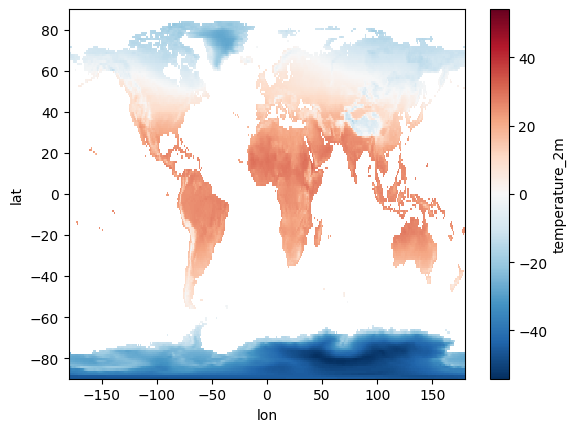

In [ ]:
climate = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
    .filterDate('1960', '2020'))

ds = xarray.open_dataset(
    climate,
    engine='ee',
    scale=1,
    crs='EPSG:4326',
    geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

deg_c = ds['temperature_2m'] - 273.15
mean_deg_c = deg_c.mean(dim='time', skipna=True)
mean_deg_c.transpose().plot()

#### Server-side computation (using Earth Engine)

Alternatively, we can perform the entire calculation on Earth Engine's servers. This involves a single call to Earth Engine's `mean()` reducer. The result is a single image representing the mean temperature over the entire time series, which is then downloaded. This dramatically reduces data transfer, leading to potentially significant performance gains, especially for larger datasets or higher spatial resolutions. The Earth Engine code is also quite readable, expressing the calculation in a clear and concise manner.



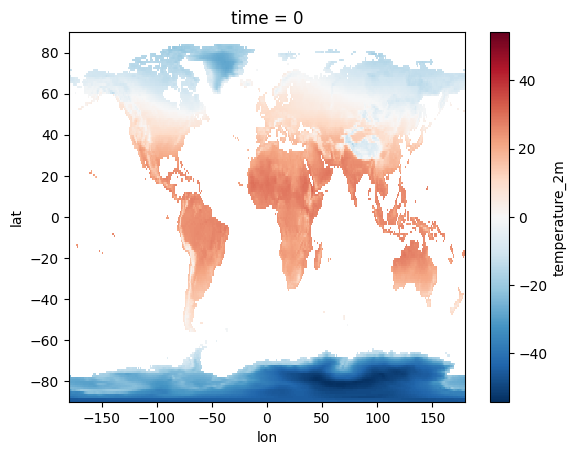

In [ ]:
mean_deg_c = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
    .filterDate('1960', '2020')
    .select('temperature_2m')
    .mean()
    .subtract(273.15))

ds = xarray.open_dataset(
    ee.ImageCollection([mean_deg_c]),
    engine='ee',
    scale=1,
    crs='EPSG:4326',
    geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

ds['temperature_2m'].transpose().plot()

#### Comparison

In this specific case, the performance advantage of server-side computation, due to minimal data transfer, likely outweighs any potential benefits of client-side flexibility. Readability is comparable in both approaches.

### Simple linear regression (July trend)

#### Client-side computation (using Xarray)

To calculate the slope of July temperature over the time series client-side, we first download all 720 monthly images. We then filter for July data using Xarray's time accessor and calculate the slope using `polyfit`. This approach gives us the full flexibility of the Python ecosystem, allowing for complex pre- and post-processing. However, it requires transferring all 720 images, a substantial amount of data.

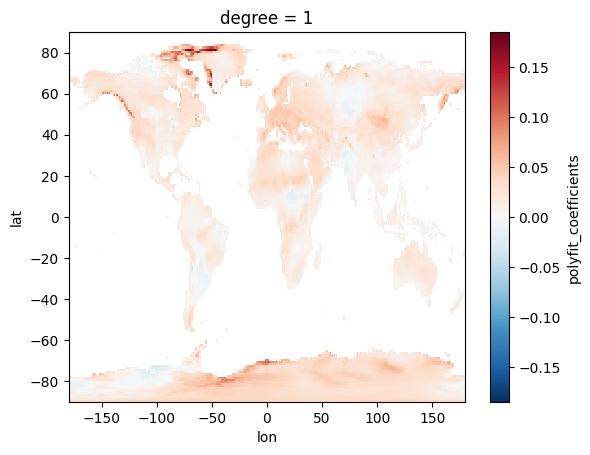

In [ ]:
climate = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020'))

ds = xarray.open_dataset(
   climate,
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

deg_c = ds['temperature_2m'] - 273.15
july_deg_c = deg_c.sel(time=deg_c.time.dt.month == 7)
july_deg_c['time_years'] = july_deg_c.time.dt.year - july_deg_c.time[0].dt.year
coeff = july_deg_c.polyfit(dim='time_years', deg=1)
slope = coeff['polyfit_coefficients'].sel(degree=1)
slope.transpose().plot()

#### Server-side computation (using Earth Engine)

With Earth Engine, we perform all computations on the server. We filter the collection for July, convert to Celsius, add a year band, and use `ee.Reducer.linearFit()` to efficiently calculate the slope. Only the resulting slope image is then downloaded. This drastically reduces data transfer compared to the client-side approach.

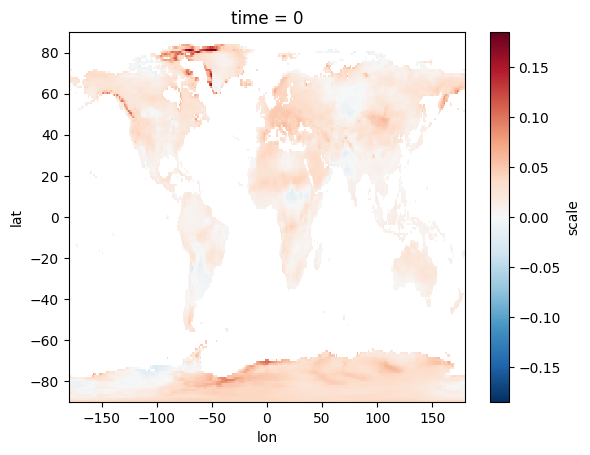

In [ ]:
def k_to_c(image):
   return image.select().addBands(image.subtract(273.15))

def add_year_band(image):
   year = ee.Image(image.date().get('year')).rename('year').toFloat()
   return image.addBands(year)

july_deg_c = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020')
   .filter(ee.Filter.calendarRange(7, None, 'month'))
   .select('temperature_2m')
   .map(k_to_c)
   .map(add_year_band))

coeff = july_deg_c.select(['year', 'temperature_2m']).reduce(
   ee.Reducer.linearFit())

ds = xarray.open_dataset(
   ee.ImageCollection([coeff]),
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

slope = ds['scale']
slope.transpose().plot()

#### Comparison

For calculating the July temperature trend slope, the server-side approach generally offers better performance due to the reduced data transfer (downloading one image vs. 720). While the client-side approach offers more flexibility with the full Python ecosystem and Xarray, this flexibility isn't necessary for this specific task. Code readability is comparable between the two approaches, with Xarray's `polyfit` being concise but Earth Engine's built-in functions also expressing the calculation clearly. Therefore, server-side computation is probably preferable in this case.

### Monthly mean temperature difference (July - January)

#### Client-side computation (using Xarray)

The client-side approach leverages the intuitive grouping capabilities of Xarray. We download the entire collection and use `groupby('time.month').mean(dim='time')` to efficiently calculate the monthly mean temperature. This approach provides a very clear and concise expression of the calculation.

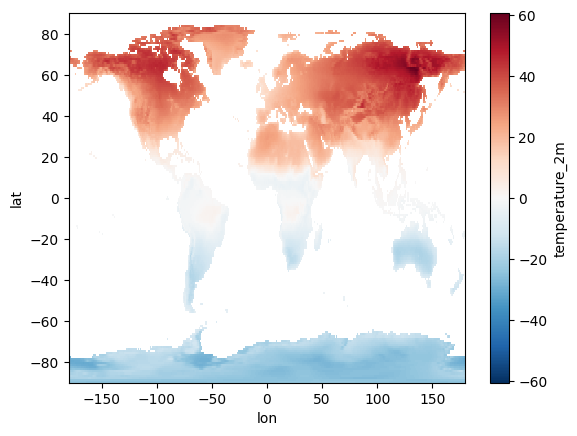

In [ ]:
climate = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020'))

ds = xarray.open_dataset(
   climate,
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

mean_deg_c = ds['temperature_2m'].groupby('time.month').mean(dim='time') - 273.15
(mean_deg_c[6] - mean_deg_c[0]).transpose().plot()

#### Server-side computation (using Earth Engine)

While Earth Engine can perform the calculation, it requires a join operation due to the need to group images by month. This involves creating helper functions and applying a join filter, which can be less intuitive compared to Xarray's concise grouping syntax.

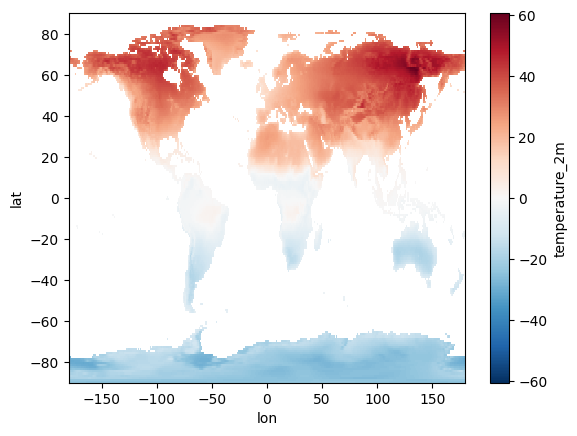

In [ ]:
def k_to_c(image):
   return image.select().addBands(image.subtract(273.15))

def add_month_attribute(image):
   month = image.date().get('month')
   return image.set('month', month)

deg_c = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020')
   .select('temperature_2m')
   .map(k_to_c)
   .map(add_month_attribute))

deg_c_by_month = deg_c.distinct('month')

filter = ee.Filter.equals(leftField='month', rightField='month')
join = ee.Join.saveAll('month_match')
deg_c_by_month = join.apply(deg_c_by_month, deg_c, filter)

def get_month_mean_across_years(image):
   deg_c_mean = ee.ImageCollection.fromImages(image.get('month_match')).mean()
   return deg_c_mean.set('month', image.get('month'))

deg_c_by_month = deg_c_by_month.map(get_month_mean_across_years)

ds = xarray.open_dataset(
   ee.ImageCollection(deg_c_by_month),
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

mean_deg_c = ds['temperature_2m']
(mean_deg_c[6] - mean_deg_c[0]).transpose().plot()

#### Comparison

For calculating the monthly mean temperature difference with a focus on code readability, the client-side approach using Xarray is preferable. The grouping syntax is more natural and easier to follow. In situations where performance is a major concern (e.g., extremely large datasets or very high resolutions), the performance characteristics of each approach should be carefully evaluated, but in this case, the readability advantage of Xarray makes it a strong choice.